<a href="https://colab.research.google.com/github/BYU-Hydroinformatics/ggst-notebooks/blob/main/ggst_api.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grace Groundwater Subsetting Tool (GGST) API Walk through

### This notebook will walk you through the various API calls in the GGST Tethys app

##### In order to run this notebook the user will have to sign up for an account on [tethys-staging.byu.edu](https://tethys-staging.byu.edu). Use the login button to get a sign-up prompt. After signing in you can retrieve your API authentication token via the User Settings.

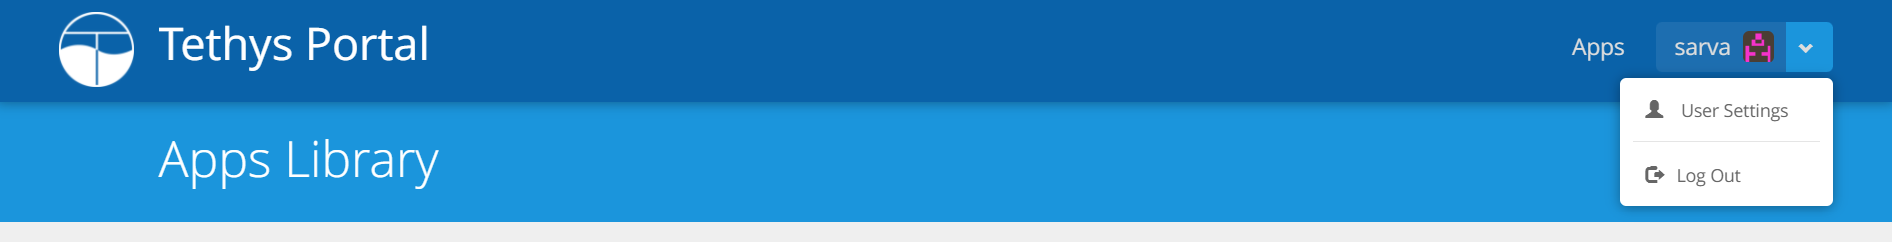

It is in the third section of the User Settings Page
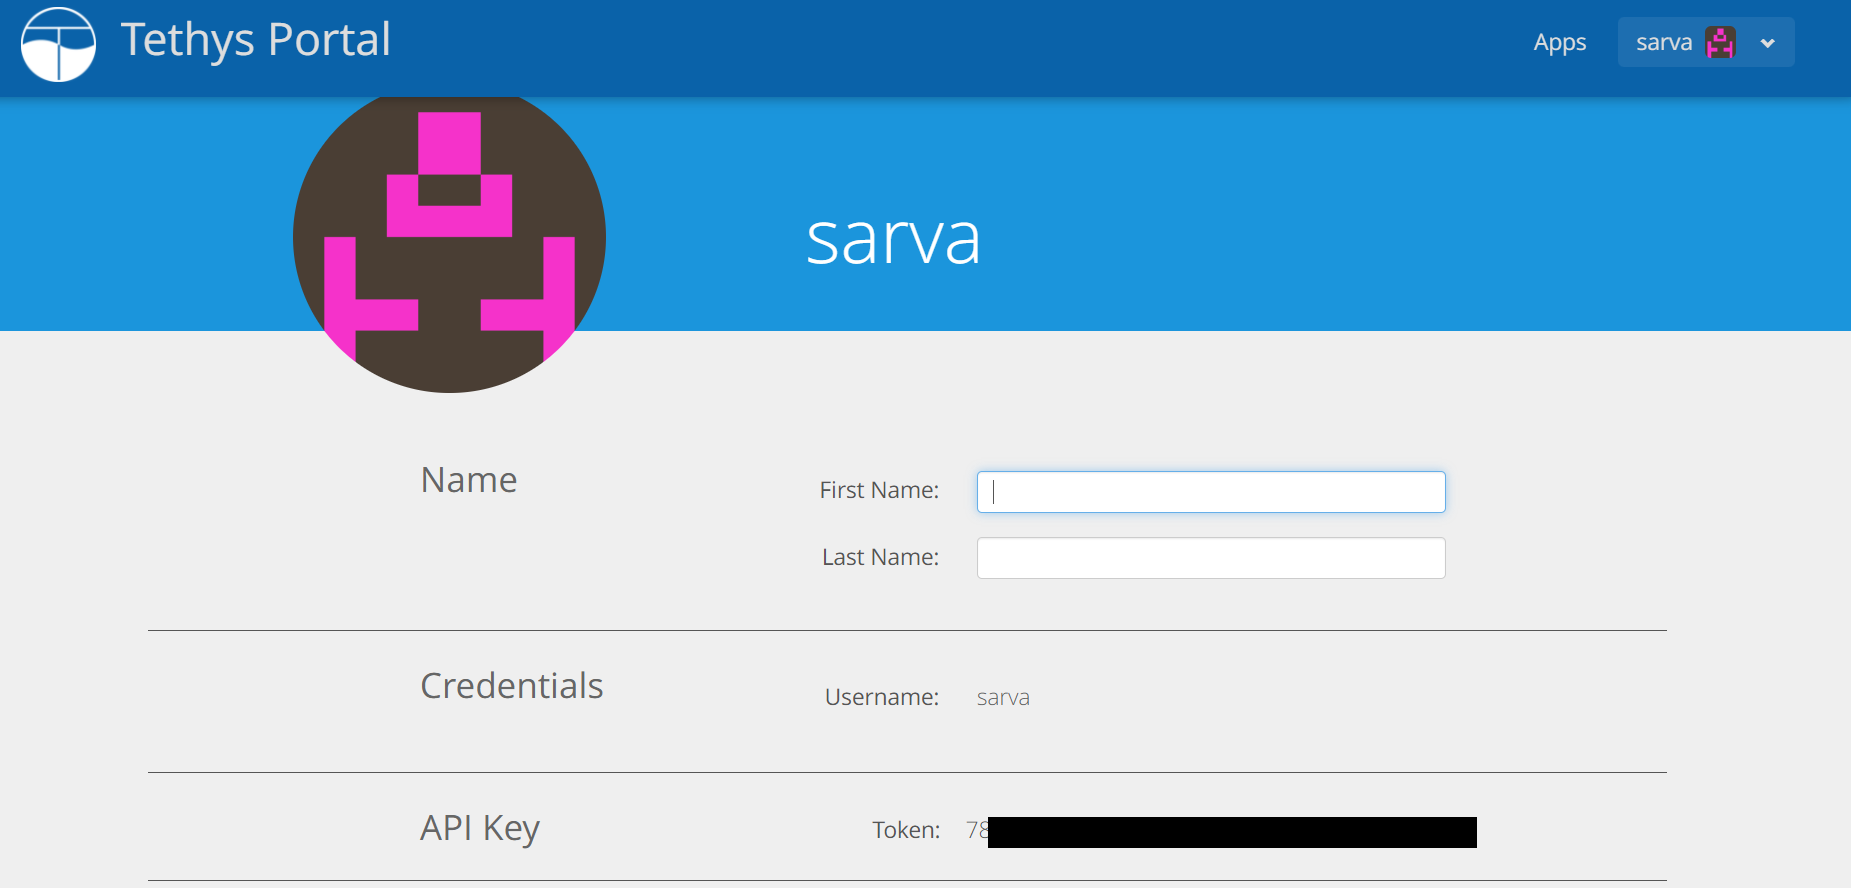

## **Instructions:**
*This is a Google Colab Notebook, shared via Github. That means that you can perform operations within this notebook and download your files once you're done. Once you restart the session (e.g. refresh the page) your changes will not be saved. However, you can save a copy of this notebook using the "File" tab.*
* To use this tool, follow the instructions in the right side of each cell. 
* **To run each cell, press the play button on the left. Occasionally, the cell will require additional input after pressing the play button.**
* If an error appears, double check that all input options are correct.

In [ ]:
#@markdown ### **Run this cell to install dependencies**
# Install dependencies
%%capture
!pip install xarray 
!pip install geopandas

In [ ]:
#@markdown ### **Run this cell to load necessary packages**
# Load packages
%%capture
import requests

import os

from zipfile import ZipFile
from io import BytesIO, StringIO
import xarray
import json
import numpy
import pandas
from google.colab import files
import ipywidgets as widgets
import sys
import matplotlib.pyplot as plt

In [ ]:
#@markdown ### **Run this cell to upload shapefile zip**
# Upload zipfile
uploaded = files.upload()

In [ ]:
#@markdown ### **Run this cell to setup the files request for the API**
files = {'shapefile': ("response.zip", uploaded["".join(uploaded)],'application/zip')}

In [ ]:
#@markdown ### **Run this cell to declare the API token**
# Get API Token from User Settings on the Tethys Portal. 
# Note: You have to be logged in to access User Settings
api_token = ""

In [ ]:
#@markdown ### **Run this cell to view storage options**
# View available storage types
storage_options = requests.get("https://tethys-staging.byu.edu/apps/ggst/api/getStorageOptions/")
storage_options.json()

In [ ]:
#@markdown ### **Run this cell to make timeseries request for a region**
# Initialize timeseries request. API Token is passed in the headers for authorization.
# Name and Storage Type parameters are passed in the data dictionary object
region_name = "api_test"
storage_type = "grace"
data_obj = {"name": region_name,
            "storage_type": storage_type}
region_timeseries_request = requests.post("https://tethys-staging.byu.edu/apps/ggst/api/getRegionTimeseries/",
                                          headers={"Authorization": f"Token {api_token}"},
                                          data = data_obj, 
                                          files=files)

In [ ]:
#@markdown ### **Run this cell to make convert the request to dataframe and then plot it**

# Get the json object from the request
region_ts_json = region_timeseries_request.json()
# Create a dataframe from the JSON for plotting
region_ts = (pandas.DataFrame(columns=["date", "ts"], data=region_ts_json["values"])
            .merge(pandas.DataFrame(columns=["date", "error_min", "error_max"], data=region_ts_json["error_range"]), on="date"))
region_ts["date"] =  pandas.to_datetime(region_ts.date)
# Plot the dataframe with error range
fig, ax = plt.subplots(1, 1, figsize=(25,5))
ax.plot(region_ts.date, region_ts.ts)
ax.fill_between(region_ts.date, region_ts.error_min, region_ts.error_max, alpha=0.35)
ax.set_title("Storage Timeseries")

# Workflow to request raw data and plotting raw data

In [ ]:
#@markdown ### **Run this cell to request zipfile and extract its content**
# Declare region name
region_name = "api_test"
data_obj = {"name": region_name}
subset_region_request = requests.post("https://tethys-staging.byu.edu/apps/ggst/api/subsetRegionZipfile/",
                                      headers={"Authorization": f"Token {api_token}"},
                                      data = data_obj, files=files)
# Save the request response and extract the files
z = ZipFile(BytesIO(subset_region_request.content))
z.extractall()

In [ ]:
#@markdown ### **Run this cell to initiate function for regional timeseries**
# Helper function to calculate regional timeseries for raw data
def get_regional_ts(region, storage_type, grace_dir):
    graph_json = {}
    ts_plot = []
    ts_plot_int = []
    error_range = []
    nc_file = os.path.join(grace_dir, f"{region}_{storage_type}.nc")
    ds = xarray.open_dataset(nc_file)
    region_area = json.load(open(os.path.join(grace_dir, "area.json"), "r"))[
        "area"
    ]
    lwe_da = ds.lwe_thickness.mean(["lat", "lon"])
    error_da = ds.uncertainty.mean(["lat", "lon"])

    init_value = lwe_da.values[0]
    for x, y in zip(lwe_da, error_da):
        value = x.values
        error_bar = y.values
#         utc_time = int(x.time.values.astype(int) / 1000000)
        utc_time = x.time.values
        difference_data_value = (value - init_value) * 0.00000075 * region_area
        ts_plot.append([utc_time, round(float(value), 3)])
        error_range.append(
            [
                utc_time,
                round(float(value - error_bar), 3),
                round(float(value + error_bar), 3),
            ]
        )
        ts_plot_int.append([utc_time, round(float(difference_data_value), 3)])

    graph_json["values"] = ts_plot
    graph_json["depletion_values"] = ts_plot_int
    graph_json["error_range"] = error_range
    graph_json["area"] = region_area
    df = (pandas.DataFrame(ts_plot, columns=["time", "value"])
          .merge(pandas.DataFrame(ts_plot_int, columns=["time", "depletion"]))
          .merge(pandas.DataFrame(error_range, columns=["time", "min_bar", "max_bar"])))
    df["time"] = pandas.to_datetime(df["time"])
    return graph_json, df

In [ ]:
#@markdown ### **Run this cell to get Groundwater Anomaly Timeseries**

# Example for plotting Ground Water
gw_json, gw_df = get_regional_ts("api_test", "gw", "api_test")
gw_df

In [ ]:
#@markdown ### **Run this cell to plot Groundwater Anomaly Timeseries and Depletion Curve**
# Plotting two timeseries
fig, ax = plt.subplots(2, 1, figsize=(25, 10))
ax[0].plot(gw_df.time, gw_df.value)
ax[0].fill_between(gw_df.time, gw_df.min_bar, gw_df.max_bar, alpha=0.35)
ax[0].set_title("Storage Timeseries")
ax[1].plot(gw_df.time, gw_df.depletion)
ax[1].set_title("Depletion Curve")
plt.subplots_adjust(wspace=0.4, hspace=0.5)